In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from transformers import BertTokenizerFast as BertTokenizer

from bert_settings import BATCH_SIZE, N_EPOCHS, MAX_TOKEN_COUNT, BERT_MODEL_NAME
from bert_utils import ClassifierModel, DataModule

from metrics import confusion_matrix_plot, calculate_recall, calculate_roc_auc, calculate_precision
from preprocessing import process_data

In [3]:
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [4]:
data = pd.read_csv('data/testset_C.csv', sep=';')
data = process_data(data)

train_data, test_data = train_test_split(data, stratify=data['productgroup'], test_size=0.2, random_state=1)

enc = OneHotEncoder(sparse=False)
train_y = enc.fit_transform(train_data[['productgroup']])
test_y = enc.transform(test_data[['productgroup']])

In [5]:
steps_per_epoch = len(train_data) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

model = ClassifierModel(
    n_classes=4,
    n_warmup_steps=10,
    n_training_steps=total_training_steps
)



data_module = DataModule(
    train_data,
    test_data,
    tokenizer,
    train_y,
    test_y,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="bert-model-v2-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)
logger = TensorBoardLogger("lightning_logs", name="text-classification")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=[0],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, data_module)

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/jovyan/work/nemo_s2t/notebooks_old/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 109 M 
1 | classifier | Linear           | 3.1 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.941   Total

Epoch 0:  80%|███████▉  | 214/268 [02:48<00:42,  1.27it/s, loss=0.0286, v_num=3, train_loss=0.0128]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 268/268 [03:01<00:00,  1.48it/s, loss=0.0286, v_num=3, train_loss=0.0128, val_loss=0.0347]

Epoch 0, global step 214: 'val_loss' reached 0.03466 (best 0.03466), saving model to '/home/jovyan/work/nemo_s2t/notebooks_old/checkpoints/bert-model-v2-epoch=00-val_loss=0.03.ckpt' as top 1


Epoch 1:  80%|███████▉  | 214/268 [02:29<00:37,  1.43it/s, loss=0.0102, v_num=3, train_loss=0.00368, val_loss=0.0347] 
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 268/268 [02:42<00:00,  1.65it/s, loss=0.0102, v_num=3, train_loss=0.00368, val_loss=0.0179]

Epoch 1, global step 428: 'val_loss' reached 0.01794 (best 0.01794), saving model to '/home/jovyan/work/nemo_s2t/notebooks_old/checkpoints/bert-model-v2-epoch=01-val_loss=0.02.ckpt' as top 1


Epoch 2:  80%|███████▉  | 214/268 [02:29<00:37,  1.43it/s, loss=0.0076, v_num=3, train_loss=0.00266, val_loss=0.0179] 
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 268/268 [02:42<00:00,  1.65it/s, loss=0.0076, v_num=3, train_loss=0.00266, val_loss=0.0179]

Epoch 2, global step 642: 'val_loss' was not in top 1


Epoch 3:  80%|███████▉  | 214/268 [02:28<00:37,  1.44it/s, loss=0.00168, v_num=3, train_loss=0.00152, val_loss=0.0179]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 268/268 [02:42<00:00,  1.65it/s, loss=0.00168, v_num=3, train_loss=0.00152, val_loss=0.0174]

Epoch 3, global step 856: 'val_loss' reached 0.01743 (best 0.01743), saving model to '/home/jovyan/work/nemo_s2t/notebooks_old/checkpoints/bert-model-v2-epoch=03-val_loss=0.02.ckpt' as top 1


Epoch 4:  80%|███████▉  | 214/268 [02:30<00:37,  1.42it/s, loss=0.00156, v_num=3, train_loss=0.00118, val_loss=0.0174]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 268/268 [02:43<00:00,  1.64it/s, loss=0.00156, v_num=3, train_loss=0.00118, val_loss=0.0157]

Epoch 4, global step 1070: 'val_loss' reached 0.01572 (best 0.01572), saving model to '/home/jovyan/work/nemo_s2t/notebooks_old/checkpoints/bert-model-v2-epoch=04-val_loss=0.02.ckpt' as top 1


Epoch 5:  80%|███████▉  | 214/268 [02:29<00:37,  1.43it/s, loss=0.00124, v_num=3, train_loss=0.00147, val_loss=0.0157] 
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 268/268 [02:42<00:00,  1.64it/s, loss=0.00124, v_num=3, train_loss=0.00147, val_loss=0.023]

Epoch 5, global step 1284: 'val_loss' was not in top 1


Epoch 6:  80%|███████▉  | 214/268 [02:30<00:37,  1.42it/s, loss=0.000856, v_num=3, train_loss=0.000804, val_loss=0.023]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 268/268 [02:43<00:00,  1.63it/s, loss=0.000856, v_num=3, train_loss=0.000804, val_loss=0.0187]

Epoch 6, global step 1498: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 268/268 [02:44<00:00,  1.63it/s, loss=0.000856, v_num=3, train_loss=0.000804, val_loss=0.0187]


In [8]:
state_dict = torch.load('checkpoints/bert-model-epoch=04-val_loss=0.02.ckpt', map_location='cpu')
model.load_state_dict(state_dict['state_dict'])
model.eval()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model.to(device)

ClassifierModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [15]:
loader = data_module.val_dataloader()
softmax = torch.nn.Softmax()

predicts = []
true = []

for batch in loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"]
    with torch.no_grad():
        loss, out = model.forward(input_ids, attention_mask)
    res = softmax(out).detach().cpu().numpy()
    predicts.extend(res.tolist())
    true.extend(labels.detach().cpu().numpy().tolist())

/tmp/ipykernel_271953/2802461268.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = softmax(out).detach().cpu().numpy()


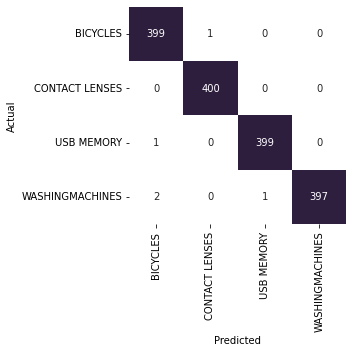

In [19]:
confusion_matrix_plot(true, predicts, enc.categories_[0])

In [22]:
preds_bool = np.round(predicts)

In [23]:
calculate_recall(true, preds_bool)
calculate_precision(true, preds_bool)
calculate_roc_auc(true, predicts)


    recall: 0.9969
    

    precision: 0.9969
    

    roc auc macro: 0.9999,
    roc auc micro: 0.9999
    


In [24]:
predicted_cat = np.argmax(predicts, axis=1)
true_cat = np.argmax(true, axis=1)

wrong_indexes = np.where(predicted_cat != true_cat)[0]
ind_to_category = {ind: cat for ind, cat in enumerate(enc.categories_[0])}

for i in wrong_indexes:
    print(test_data['concat_text'].iloc[i])
    print(f'true_cat: {ind_to_category[true_cat[i]]}', f'predicted: {ind_to_category[predicted_cat[i]]}')
    print()

polar polar pulsuhr v800 hr  black  90060770 sports 29000multisports 29170heartratewatches sportscomputers gpsde
true_cat: WASHINGMACHINES predicted: USB MEMORY

None proph md wave aktion 0 63
true_cat: BICYCLES predicted: CONTACT LENSES

None kingston data traveler se9 mit 109
true_cat: USB MEMORY predicted: BICYCLES

candy candy evot 1005 1d weiss 6
true_cat: WASHINGMACHINES predicted: BICYCLES

candy gs 1482 d3 32516 washing machines
true_cat: WASHINGMACHINES predicted: BICYCLES

